In [1]:
%load_ext watermark
%watermark

Last updated: 2021-05-02T10:49:13.192318+02:00

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 12.0.0 (clang-1200.0.32.29)
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



In [2]:
import pandas as pd
import numpy as np 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,12)
plt.rcParams['font.size'] = 16

In [4]:
vehicles = pd.read_csv("../data/vehicles_processed.csv",
                      usecols=["consumption", "CO2_emissions","cylinders", "displ"])

litres_per_galon = 3.78541
vehicles["consumption_litres_mile"] = litres_per_galon / vehicles.consumption

In [5]:
vehicles.shape

(35539, 5)

In [6]:
vehicles.head()

,displ,cylinders,consumption,CO2_emissions,consumption_litres_mile
0,2.5,4.0,17,522.764706,0.222671
1,4.2,6.0,13,683.615385,0.291185
2,2.5,4.0,16,555.437500,0.236588
3,4.2,6.0,13,683.615385,0.291185
4,3.8,6.0,16,555.437500,0.236588


The model of linear regression OLS we are using will enable to predict a variable 'y'.

We specify the percentage of training dataset percentage over the total dataset

In [7]:
pct_training = 0.8

In [8]:
vehicles_training = vehicles.sample(frac= pct_training)

vehicles_test =  vehicles[~vehicles.index.isin(vehicles_training.index)]

print(vehicles_training.shape)
print(vehicles_test.shape)

(28431, 5)
(7108, 5)


In [9]:
independent_variables = ["displ","cylinders","consumption_litres_mile"]
dependent_variable = "CO2_emissions"
X = vehicles_training[independent_variables].values
y = vehicles_training[dependent_variable].values
X_T = X.T

In [10]:
X

array([[2.        , 4.        , 0.1514164 ],
       [2.        , 4.        , 0.18025762],
       [2.3       , 4.        , 0.16458304],
       ...,
       [3.2       , 6.        , 0.22267118],
       [2.4       , 5.        , 0.17206409],
       [1.9       , 4.        , 0.13519321]])

In [11]:
X.shape

(28431, 3)

In [12]:
y

array([355.48      , 423.19047619, 386.39130435, ..., 522.76470588,
       403.95454545, 317.39285714])

In [13]:
betas = np.linalg.inv(X_T @ X) @ X_T @ y
betas

array([ 3.71488359e+00, -5.27011629e-01,  2.30476614e+03])

In [14]:
y.mean()

470.0978498287583

In [24]:
alpha = y.mean() - np.dot(betas, vehicles_training[independent_variables].mean().values)
alpha

0.3748615456070752

In [25]:
def predict(r):
    return alpha + np.dot(betas, r.values)

In [17]:
vehicles_training["CO2_pred"] = vehicles_training[independent_variables].apply(
    predict, axis=1)
vehicles_test["CO2_pred"] = vehicles_test[independent_variables].apply(predict, axis=1)

<ipython-input-17-3966b2e5a8cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicles_test["CO2_pred"] = vehicles_test[independent_variables].apply(predict, axis=1)


In [18]:
vehicles_training[["CO2_emissions", "CO2_pred"]].head()

,CO2_emissions,CO2_pred
20320,355.480000,354.675974
346,423.190476,421.148240
31513,386.391304,386.136474
31897,370.291667,366.616364
7685,403.954545,402.264073


In [19]:
vehicles_training.dtypes

displ                      float64
cylinders                  float64
consumption                  int64
CO2_emissions              float64
consumption_litres_mile    float64
CO2_pred                   float64
dtype: object

In [29]:
model_formula = 'y ~ {alpha:.3f} + {beta_1:.2f}*displ + {beta_2:.2f}*cylinders + {beta_3:.3f}*consumption_litres_mile'.format(
    alpha=alpha, beta_1= betas[0], beta_2=betas[1], beta_3=betas[2])
model_formula

'y ~ 0.375 + 3.71*displ + -0.53*cylinders + 2304.766*consumption_litres_mile'

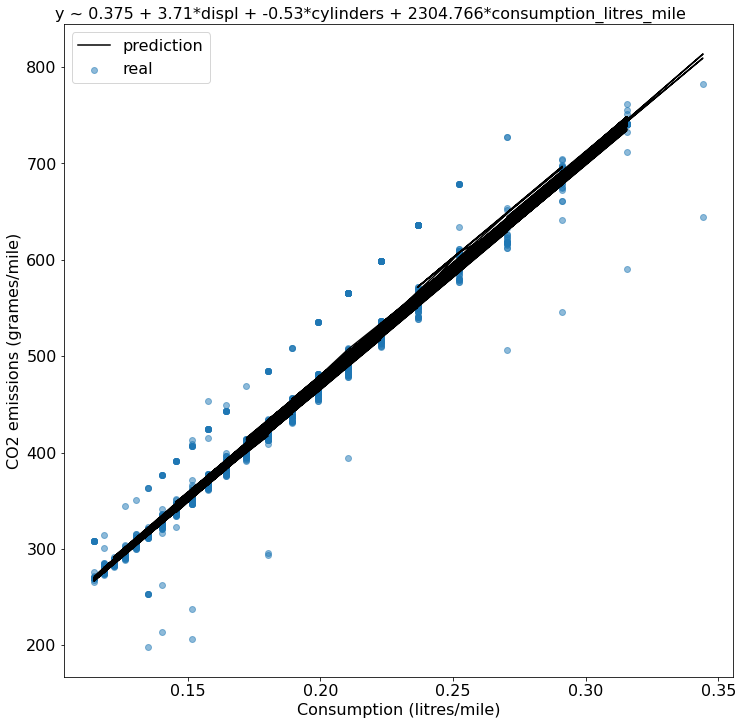

In [30]:
plt.scatter(vehicles_test.consumption_litres_mile, vehicles_test.CO2_emissions, alpha=0.5, label="real")
plt.text(0.1, 850, model_formula)
plt.plot(vehicles_test.consumption_litres_mile, vehicles_test.CO2_pred, c = "black", label="prediction")
plt.xlabel("Consumption (litres/mile)")
plt.ylabel("CO2 emissions (grames/mile)")
plt.legend()

In [33]:
def mean_square_error(y, y_pred):
    return np.sum((y-y_pred)**2/len(y))

In [35]:
training_error = mean_square_error(vehicles_training.CO2_emissions, vehicles_training.CO2_pred)
training_error

134.05835431084586

In [37]:
test_error = mean_square_error(vehicles_test.CO2_emissions, vehicles_test.CO2_pred)
test_error

120.36336074509913